<a id="top"></a>

# Reddit Analyzer for McAfee Posts

This Jupyter notebook implements a **Reddit analyzer** focused on posts about **McAfee antivirus software**. It utilizes several APIs and libraries including:

- <span style="color:blue">**PRAW**</span> - Reddit API wrapper 
- <span style="color:blue">**OpenAI**</span> - GPT-3 API
- <span style="color:blue">**TextBlob**</span> - Text processing/NLP
- <span style="color:blue">**SpaCy**</span> - Advanced NLP 

## Key Steps

- Search Reddit for posts containing keywords like **"McAfee"**

- Use **OpenAI's GPT-3** to <span style="color:green">**classify posts**</span> as relevant or not to McAfee antivirus

- <span style="color:green">**Save**</span> classified posts to a CSV file

- **Analyze** top subreddits where McAfee is discussed 

- Retrieve posts and <span style="color:green">**analyze sentiment**</span> over time using TextBlob

- <span style="color:green">**Train**</span> a SpaCy text classification model on the classified post data

- <span style="color:green">**Evaluate**</span> model accuracy on a validation set

- Improve model by <span style="color:green">**merging**</span> additional labeled data

- Experiment with <span style="color:green">**fine-tuning BERT**</span> in TensorFlow for the text classification task

- Use the final model to classify new Reddit posts and <span style="color:green">**plot sentiment trends**</span> over time

## Table of Contents

- Get Training Data [Link](#get-training-data)

- Search Subreddits For Products [Link](#search-subreddits-for-products)

- Stacked Bar of Products Per Sub [Link](#stacked-bar-of-products-per-sub)

- Trend Sentiment for Other Prodcts [Link](#trend-sentiment-for-other-products)

- Train a Simple Bag of Words Model [Link](#train-simple-bag-of-words-model)

- Validate The Model [Link](#validate-the-model)

- Train a Larger BERT Model [Link](#train-a-larger-bert-model)

- Trend McAfee Sentiment Across All Subs [Link](#trend-mcafee-sentiment-across-all-subs)

## Key Takeaways

The notebook demonstrates an **end-to-end pipeline** for:

- Gathering social media data
- Training a classifier using ML 
- Generating insights around product sentiment

Key techniques used include:

- Transfer learning 
- Data labeling
- Model evaluation
- Time series visualization

In [1]:
import os
from dotenv import load_dotenv
from textblob import TextBlob
import pandas as pd
import matplotlib.pyplot as plt
import openai
import praw
import csv
import pytesseract
from PIL import Image
import requests
from io import BytesIO
import time



In [2]:
# Load creditials from .env

load_dotenv()
openai.api_key = os.getenv("OPENAI_API_KEY")
reddit = praw.Reddit(
    client_id=os.getenv("CLIENT_ID"),
    client_secret=os.getenv("CLIENT_SECRET"),
    user_agent=os.getenv("USER_AGENT"),
    username=os.getenv("USERNAME"),
    password=os.getenv("PASSWORD"),
)

In [3]:
# Functions for converting image to text and truncating the output
def image_to_text(img_url):
    try:
        response = requests.get(img_url)
        image = Image.open(BytesIO(response.content))
        return pytesseract.image_to_string(image)
    except:
        return ""
    
def truncate_text_to_fit(text, title, max_tokens=200):
    """Truncates the given text to fit within the model's token limit."""
    
    # Estimate the number of tokens used by other parts of the prompt
    extra_tokens = len(title) + len("Considering the title \"\" and its content \"\", without providing any additional context or unnecessary text, is the topic primarily about McAfee antivirus software products? Reply only with 'Yes' or 'No'.")
    
    # Determine how many tokens are left for the content text
    available_tokens = max_tokens - extra_tokens
    
    # Truncate the text to the available tokens
    truncated_text = text[:available_tokens]
    
    return truncated_text

<a id="get-training-data"></a>

## Get Training Data

[Back to Top](#top)

In [4]:
#Query Reddit for training data
#Extract text from images
#Classify using GPT 3.5 API if its about McAfee software or not
#Write output to a CSV

subreddit = reddit.subreddit('all')
search_term = 'McAfee -"John McAfee" -"Pat McAfee"'  #ignore John and Pat
search_limit = 3 # Adjust the limit as needed for performance
output_file = "output.csv"
openai_engine = "text-davinci-002"
enable_image_recognition = True
debug_timing = True
debug_posts = True
use_openai = False

# Filter posts using GPT
relevant_posts = []
notreleveant_posts = []

posts = subreddit.search(search_term, limit=search_limit)  
# Open a CSV file to write results
with open(output_file, 'w', newline='') as csvfile:
    fieldnames = ['classification', 'post title', 'post description']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    
    # Write the header
    writer.writeheader()
    for post in posts:
        img_text = ""
        if(enable_image_recognition):
            if post.url and (".jpg" in post.url or ".png" in post.url):  # Add more image formats if needed
                if(debug_timing):
                    start_time_api = time.time()
                img_text = image_to_text(post.url)
                
                if(debug_timing):
                    end_time_api = time.time()
                    print(f"image to text took {end_time_api - start_time_api} seconds.")


        # Combine post text and image-based text
        combined_text = post.selftext + " " + img_text
        #make sure we don't exceed the context window
        combined_text = truncate_text_to_fit(combined_text, post.title)
        if(debug_posts):
            print("the combined text is: " + combined_text)
        prompt = f"Considering the title \"{post.title}\" and its content \"{combined_text}\", without providing any additional context or unnecessary text, is the topic primarily about McAfee antivirus software products? Reply only with 'Yes' or 'No'."
        if(debug_timing):
            start_time_ocr = time.time()
        
        if(use_openai):
            response = openai.Completion.create(engine=openai_engine, prompt=prompt, max_tokens=10)
            if(debug_timing):
                end_time_api = time.time()
                print(f"open AI calltook {end_time_api - start_time_api} seconds.")

            if response.choices[0].text.strip().lower() == "yes":
                relevant_posts.append(post.title)
                writer.writerow({'classification': 'MCAFEE', 'post title': post.title, 'post description': combined_text})
            else:
                notreleveant_posts.append(post.title)
                writer.writerow({'classification': 'NOT_MCAFEE', 'post title': post.title, 'post description': combined_text})
        else:
            writer.writerow({'classification': 'TBD', 'post title': post.title, 'post description': combined_text})



image to text took 1.079669713973999 seconds.
the combined text is:  FS Task Manager - ag *x

File Options View

Processes Performance Apphistory Startup Users Details Services

. 11% 38% 0% 0% 43%
Name Status CPU | Memory Disk | _ Network GPU | GPU a
Cl McAfee 0% © -30MB —-OMB/s_ «= OMbps. oY
> TY Mosfee Access Protection 0% «= 12MB_—OMB/s_—OMbps 0%
U McAfee Cloud AV 0% © 29MB_—OMB/s_—OMbps 0%
> [El Medes CSP Service Host 0% © 51MB_—OMB/s_—OMbps 0%
U Meafee File Lock Monitor 0% — O4AMB_—OMB/s_—OMbps 0%
U Mette Host 0% © 29MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 38MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 32MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 29MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 27MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 28MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 28MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 27MB_—OMB/s_—OMbps 0%
U Mette Host 0% © 27MB_—OMB/s_—OMbps 0%
> [McAfee Management Service (2) 0% © 30MB_—OMB/s_ «Ops 0%
TU McAfee Management Service Host 0% © 208MB_—OMB/s_—O Mbps 0%
U McAfee 

<a id="search-subreddits-for-products"></a>
## Search Subreddits for Products
[Back to Top](#top)


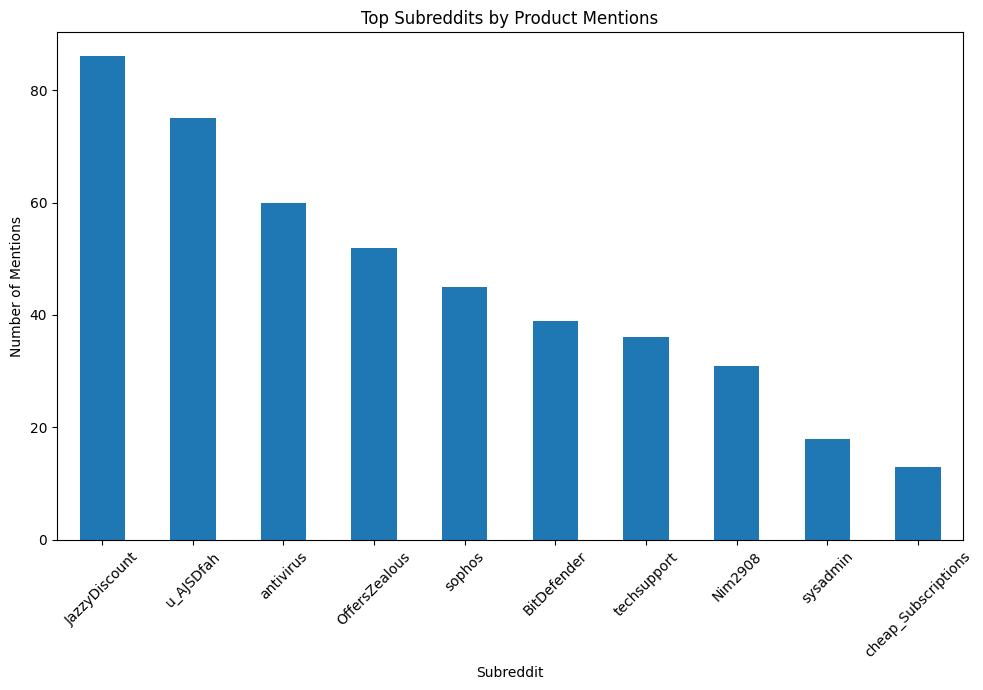

In [5]:
# Find which subreddits these products are seen in
#product_list = ['McAfee','Trend Micro','Sophos','Kaspersky Lab','ESET','Avast','AVG','Bitdefender']
product_list = ['Trend Micro','Sophos','Kaspersky Lab','ESET','Avast','Bitdefender']

# Visualize the top N subreddits (change N based on your preference)
N = 10

# Dictionary to store counts of mentions by subreddit
subreddit_counts = {}

# Number of posts to search for each product (limitation of the API)
search_limit = 20000

for product in product_list:
    for post in reddit.subreddit("all").search(product, sort="new", time_filter="month", limit=search_limit):
        sub = post.subreddit.display_name
        if sub not in subreddit_counts:
            subreddit_counts[sub] = 0
        subreddit_counts[sub] += 1

# Convert the counts dictionary to a sorted DataFrame
df_counts = pd.DataFrame(list(subreddit_counts.items()), columns=["Subreddit", "Count"]).sort_values(by="Count", ascending=False)

ax = df_counts.head(N).plot(x="Subreddit", y="Count", kind="bar", legend=False, figsize=(10, 7))
ax.set_ylabel("Number of Mentions")
ax.set_xlabel("Subreddit")
ax.set_title("Top Subreddits by Product Mentions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id="stacked-bar-of-products-per-sub"></a>
## Stacked Bar of products per sub
[Back to Top](#top)

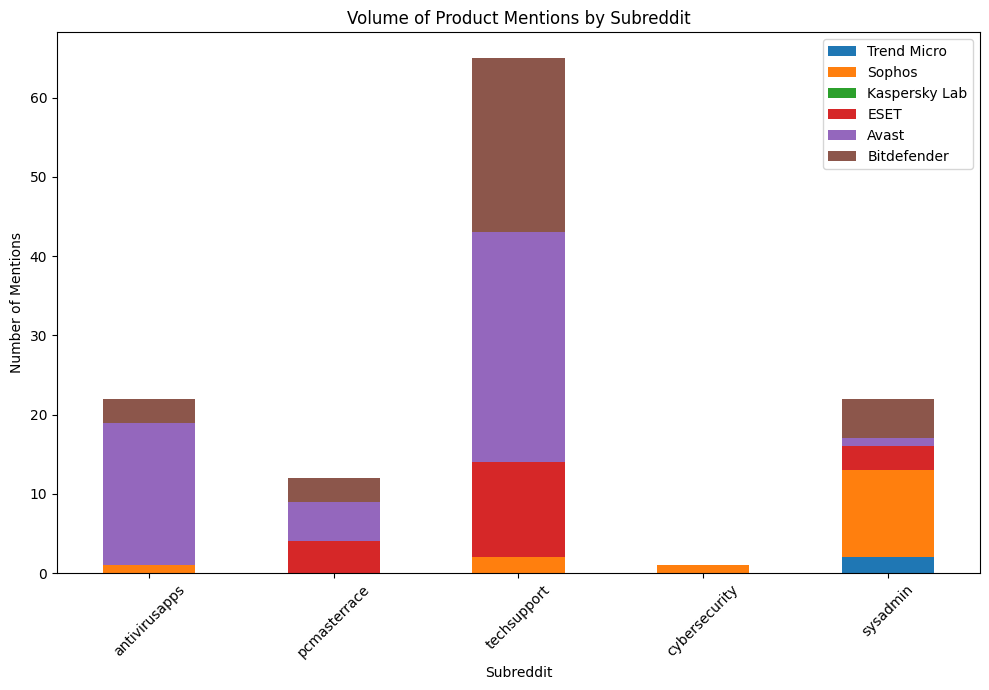

In [126]:
# Show the specific product volume in each sub
# Choose which subredits to search
subreddits_list = ["antivirusapps", "pcmasterrace", "techsupport", "cybersecurity", "sysadmin"]
product_list = ['Trend Micro','Sophos','Kaspersky Lab','ESET','Avast','Bitdefender']

# Set search query
query = ' OR '.join([f'"{product}"' for product in product_list])
# Create a nested dictionary to store counts
counts = {sub: {product: 0 for product in product_list} for sub in subreddits_list}

# Retrieve posts from subreddit and update counts
for sub in subreddits_list:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.search(query, sort="new", time_filter="month"):
        for product in product_list:
            if product.lower() in post.title.lower() or product.lower() in post.selftext.lower():
                counts[sub][product] += 1

# Convert the nested dictionary to a DataFrame
df_counts = pd.DataFrame(counts).T

# Plotting the data as a stacked bar chart
ax = df_counts.plot(kind='bar', stacked=True, figsize=(10, 7))
ax.set_ylabel("Number of Mentions")
ax.set_xlabel("Subreddit")
ax.set_title("Volume of Product Mentions by Subreddit")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<a id="trend-sentiment-for-other-products"></a>

## Trend Sentiment for Other Products
[Back to Top](#top)


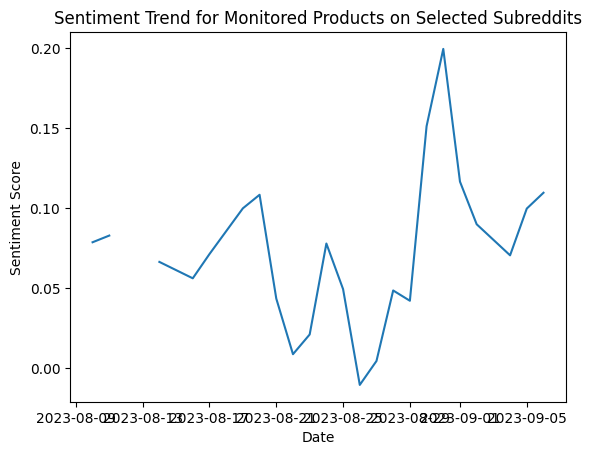

In [6]:
#trend the sentiment for a product in specific subs
subreddits_list = ["antivirusapps", "pcmasterrace", "techsupport", "cybersecurity", "sysadmin","all"]
#product_list = ['Trend Micro','Sophos','Kaspersky Lab','ESET','Avast','Bitdefender']
product_list = ['Sophos']

# Set search query
query = ' OR '.join([f'"{product}"' for product in product_list])

# Retrieve posts from subreddit
posts = []
for sub in subreddits_list:
    subreddit = reddit.subreddit(sub)
    for post in subreddit.search(query, sort="new", time_filter="month"):
        posts.append([post.title, post.selftext, post.created_utc])

# Filter posts that contain the products
product_posts = []
for post in posts:
    # Check if post title or text contains any of the products
    if any(product.lower() in text for text in [post[0].lower(), post[1].lower()] for product in product_list):
        product_posts.append(post)

# Analyze sentiment of filtered posts
sentiments = []
for post in product_posts:
    blob = TextBlob(post[0] + " " + post[1])
    sentiment = blob.sentiment.polarity
    sentiments.append([post[2], sentiment])


# Convert sentiment data to DataFrame
df = pd.DataFrame(sentiments, columns=["timestamp", "sentiment"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s").dt.date

# Calculate average sentiment score for each day

# Compute rolling average over n days
n = 7  # for example, a 7-day rolling average; you can change this value as needed
df["rolling_avg"] = df["sentiment"].rolling(window=n).mean()
df = df.groupby("date").mean().reset_index()

# Plot sentiment trend over time
plt.plot(df["date"], df["rolling_avg"])
plt.title("Sentiment Trend for Monitored Products on Selected Subreddits")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.show()


<a id="train-simple-bag-of-words-model"></a>

## Train Simple Bag Of Words Model
[Back to Top](#top)


In [128]:
#Train a simple Bag Of Words AI model to determine which posts are about McAfee software
#Output the model to the directory mcafee_classifier

folder_destination = "tmp"
epochs = 3
csv_file = "train.csv"

import spacy
import pandas as pd
from spacy.util import minibatch, compounding
from spacy.training import Example

def load_data(filename):
    df = pd.read_csv(filename)
    df['post description'].fillna('', inplace=True)
    # Create labels 'MCAFEE' or 'NOT_MCAFEE' instead of boolean
    #df['label'] = df['classification'].apply(lambda x: 'MCAFEE' if x == 'McAfee software' else 'NOT_MCAFEE')
    df['label'] = df['classification'].apply(lambda x: 'MCAFEE' if x == 'MCAFEE' else 'NOT_MCAFEE')
    return list(zip(df['post title'] + ' ' + df['post description'], df['label']))


def train_spacy_model(train_data):
    # Load a blank English model
    # nlp = spacy.blank("en")
    nlp = spacy.load("en_core_web_lg", disable=['ner'])


    #Configuration for the text categorizer
    config = {
        "model": {
            "@architectures": "spacy.TextCatBOW.v2",
            "exclusive_classes": True,
            "ngram_size": 1,
            "no_output_layer": False
        }
    }

    # Check if textcat already exists in the pipeline, if not, add it with the config
    if "textcat" not in nlp.pipe_names:
        textcat = nlp.add_pipe("textcat", config=config)
    else:
        textcat = nlp.get_pipe("textcat")

    textcat.add_label("MCAFEE")
    textcat.add_label("NOT_MCAFEE")


    # Training the model
    optimizer = nlp.create_optimizer()
    # optimizer.alpha = 0.001  # Set the initial learning rate

    for epoch in range(epochs):  # Number of epochs can be adjusted
        losses = {}
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        
        for batch in batches:
            texts, annotations = zip(*batch)
            example = []
            for i in range(len(texts)):
                cat = {'MCAFEE': annotations[i] == 'MCAFEE', 'NOT_MCAFEE': annotations[i] == 'NOT_MCAFEE'}
                example.append(Example.from_dict(nlp.make_doc(texts[i]), {"cats": cat}))
            nlp.update(example, drop=0.2, losses=losses, sgd=optimizer)

        
        print(f"Losses at epoch {epoch}: {losses}")

    # Save the model
    nlp.to_disk(folder_destination)

    print("Model saved to " + folder_destination +  " directory.")

if __name__ == "__main__":
    training_data = load_data(csv_file)
    train_spacy_model(training_data)


Losses at epoch 0: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'textcat': 18.17902585119009}
Losses at epoch 1: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'textcat': 11.343583513982594}
Losses at epoch 2: {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'textcat': 7.231453511165455}
Model saved to tmpdirectory.


<a id="validate-the-model"></a>

## Validate the Model
[Back to Top](#top)

In [7]:
#Validate the classification model with a validation data set
#90 samples takes about 3 mins
validation_csv = "validation.csv"
model_path = "mcafee_classifier"

import spacy
import pandas as pd

def load_validation_data(filename):
    df = pd.read_csv(filename)
    df['post description'].fillna('', inplace=True)
    # Assuming you still use the same label creation logic
    df['label'] = df['classification'].apply(lambda x: 'MCAFEE' if x == 'MCAFEE' else 'NOT_MCAFEE')
    return list(zip(df['post title'] + ' ' + df['post description'], df['label']))

def classify_text(model_path, text):
    nlp = spacy.load(model_path)
    doc = nlp(text)
    predicted_category = max(doc.cats, key=doc.cats.get)
    return predicted_category

if __name__ == "__main__":
    validation_data = load_validation_data(validation_csv)
    #model_path = "mcafee_classifier"

    correct_predictions = 0

    for text, true_label in validation_data:
        predicted_label = classify_text(model_path, text)
        if predicted_label == true_label:
            correct_predictions += 1
        else:
            # Optionally print out the misclassified examples for inspection
            print(f"'{text}' was misclassified as {predicted_label} instead of {true_label}")

    accuracy = correct_predictions / len(validation_data)
    print(f"Accuracy on validation set: {accuracy:.4f}")


2023-09-06 13:49:04.640651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


'[Daly] Sid Luckman, the HOF #Bears QB, just called. He said, "Read about that left-handed pass Patrick Mahomes completed to Tyreek Hill for 6 yards. Hell, I pulled that stunt in 1947 with George McAfee -- and gained *14* yards. Tell everybody to calm down." #Chiefs #NFL ' was misclassified as MCAFEE instead of NOT_MCAFEE
'This McAfee Popup notification with a hidden Close button.. Rewarded it with uninstallation ' was misclassified as NOT_MCAFEE instead of MCAFEE
'No McAfee... you are not allowed on this computer. Get out. You were never invited. ' was misclassified as NOT_MCAFEE instead of MCAFEE
'[Pat McAfee Show] Mark Stone confirmed that his wrist was broken in the 1st period of game 5 of the Stanley Cup Final. He scored a hat trick that game. ' was misclassified as NOT_MCAFEE instead of MCAFEE
'McAfee renewal worth it??? Please, I'm a novice with virus stuff... I've had McAfee Total Protection for years and kept renewing it... it's expiring tomorrow and I'm not sure I want to ren

In [91]:
#Utility to merge mulutiple dataset CSVs, randomize, and split into training and validation sets
import pandas as pd
from sklearn.utils import shuffle

def merge_and_split_csvs(file1, file2, train_output="train.csv", validation_output="validation.csv"):
    # Load the CSV files into DataFrames
    df1 = pd.read_csv(file1)
    df2 = pd.read_csv(file2)

    # Concatenate the two DataFrames
    merged_df = pd.concat([df1, df2])

    # Shuffle the merged DataFrame
    shuffled_df = shuffle(merged_df)

    # Split the DataFrame into training and validation sets
    train_size = int(0.8 * len(shuffled_df))
    train_df = shuffled_df[:train_size]
    validation_df = shuffled_df[train_size:]

    # Save the DataFrames to CSV files
    train_df.to_csv(train_output, index=False)
    validation_df.to_csv(validation_output, index=False)

if __name__ == "__main__":
    merge_and_split_csvs("230_refined_search.csv", "230_samples_edited.csv")


<a id="train-a-larger-bert-model"></a>

## Train a larger BERT Model
[Back to Top](#top)

In [103]:
#Train and Validate a much more advanced BERT model for classification
#Can take hours to run

import pandas as pd
import tensorflow as tf
from transformers import BertTokenizer, TFBertForSequenceClassification
from sklearn.model_selection import train_test_split

def load_data(filename):
    df = pd.read_csv(filename)
    df['post description'].fillna('', inplace=True)
    df['label'] = df['classification'].apply(lambda x: 1 if x == 'MCAFEE' else 0)
    return df['post title'] + ' ' + df['post description'], df['label']

def train_tf_model(train_texts, train_labels):
    # Load BERT tokenizer and model
    model_name = "bert-base-uncased"
    tokenizer = BertTokenizer.from_pretrained(model_name)
    model = TFBertForSequenceClassification.from_pretrained(model_name, num_labels=2)
    
    # Tokenize the input (with suitable max length)
    max_length = 256
    train_encodings = tokenizer(train_texts.tolist(), truncation=True, padding='max_length', max_length=max_length, return_tensors="tf")

    # Convert labels to tensor
    train_labels = tf.convert_to_tensor(train_labels.tolist())

    # Define optimizer, loss, and metrics
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    metrics = ['accuracy']

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    # Train the model
    model.fit(train_encodings["input_ids"], train_labels, batch_size=8, epochs=3, validation_split=0.1)
    
    # Save the model
    model.save_pretrained("mcafee_classifier_tf")
    tokenizer.save_pretrained("mcafee_classifier_tf")

if __name__ == "__main__":
    texts, labels = load_data("train.csv")
    train_tf_model(texts, labels)


2023-09-04 18:27:38.357862: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/3
41/41 [==============================] - 323s 7s/step - loss: 0.6170 - accuracy: 0.7046 - val_loss: 0.5686 - val_accuracy: 0.6757
Epoch 2/3
41/41 [==============================] - 294s 7s/step - loss: 0.5771 - accuracy: 0.7323 - val_loss: 0.6619 - val_accuracy: 0.6757
Epoch 3/3
41/41 [==============================] - 293s 7s/step - loss: 0.5750 - accuracy: 0.7354 - val_loss: 0.2724 - val_accuracy: 0.8649


<a id="trend-mcafee-sentiment-across-all-subs"></a>

## Trend McAfee Sentiment Across All Subs
[Back to Top](#top)

Post:
 McAfee having 20+ processes open while being unable to close any of them
Sentiment:
-0.25
Post:
 Worse than McAfee
Sentiment:
-0.4
Post:
 McAfee giving Chrome a run for its money
Sentiment:
0.0
Post:
 I am looking into buying a gaming pc and HP is trying to force me to use McAfee for at least a month, no 'No, thanks' option or anything like that.
Sentiment:
-0.2
Post:
 McAfee doesn't allow me to go into the settings and constantly gives me a pop up to use their shit again.
Sentiment:
-0.1
Post:
 I roasted McAfee. Also, the reason I took a photo instead of screenshot is because McAfee is so evil that they coded so that you can't take screenshot of the uninstall/feedback screen
Sentiment:
-1.0
Post:
 Thanks for warning me, McAfee
Sentiment:
0.2
Post:
 McAfee inflates unintall times, to try to make you cancel it. this is after 10 minutes. brand new computer.
Sentiment:
0.13636363636363635
Post:
 This McAfee “ad” to make sure you activate it forced into your agenda on every single d

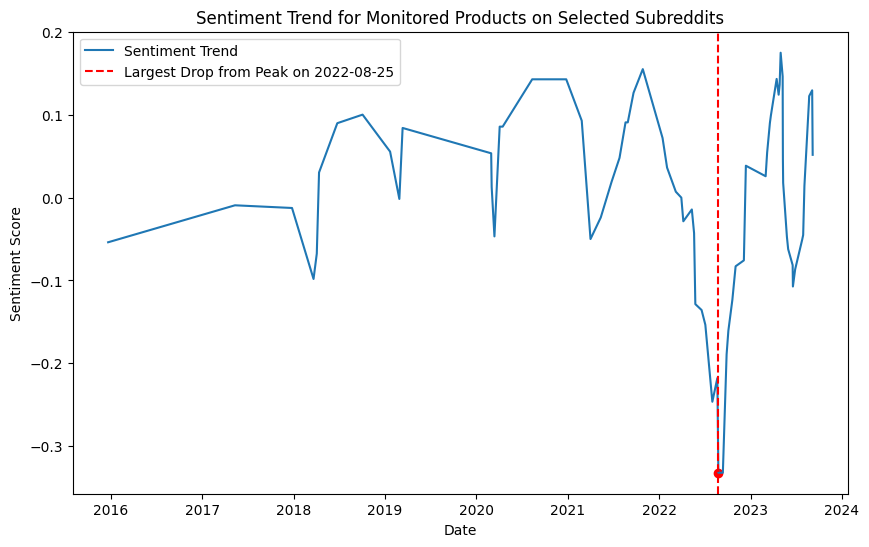

Negative Posts from 2022-08-19 to 2022-08-25 contributing to the largest drop:
Date: 2022-08-25
Title: When downloading Adobe Acrobat, it forces you to also get McAfee Security crap
Selftext: 
Sentiment: -0.8
---------------------


In [11]:
#  Trend McAfee software sentiment accross all subs using AI classifier to filter out non-software posts
#  Get posts from subreddit
subreddit = reddit.subreddit('all')
search_term = 'McAfee -"John McAfee" -"Pat McAfee"'
posts = subreddit.search(search_term, limit=1000)  # Adjust the limit as needed

relevant_posts = []
sentiments = []
for post in posts:
    combined_text = post.selftext + " " + post.title
    if classify_text(model_path, combined_text) == "MCAFEE":
        relevant_posts.append(post)
        blob = TextBlob(combined_text)
        sentiment = blob.sentiment.polarity
        sentiments.append([post.created_utc, sentiment])
        print("Post:")
        print(combined_text)
        print("Sentiment:")
        print(sentiment)
# Convert sentiment data to DataFrame
df = pd.DataFrame(sentiments, columns=["timestamp", "sentiment"])
df["date"] = pd.to_datetime(df["timestamp"], unit="s").dt.date

# Calculate average sentiment score for each day
df = df.groupby("date").mean().reset_index()

# Compute the rolling average with a window size of, let's say, 7 days
window_size = 7
df["rolling_sentiment"] = df["sentiment"].rolling(window=window_size).mean()


# Compute the rolling average with a window size of, let's say, 7 days
window_size = 7
df["rolling_sentiment"] = df["sentiment"].rolling(window=window_size).mean()

# Compute the rolling max up to the current point to identify the peak before any given day
df["previous_peak"] = df["rolling_sentiment"].cummax()

# Calculate the difference from the previous peak
df["drop_from_peak"] = df["rolling_sentiment"] - df["previous_peak"]

# Find the date with the largest drop from the previous peak
largest_drop_date = df.iloc[df["drop_from_peak"].idxmin()]["date"]

# Highlight the date with the largest drop on the plot
plt.figure(figsize=(10,6))
plt.plot(df["date"], df["rolling_sentiment"], label="Sentiment Trend")
plt.axvline(x=largest_drop_date, color='r', linestyle='--', label=f"Largest Drop from Peak on {largest_drop_date}")
plt.scatter(largest_drop_date, df[df["date"] == largest_drop_date]["rolling_sentiment"], color='red')
plt.title("Sentiment Trend for Monitored Products on Selected Subreddits")
plt.xlabel("Date")
plt.ylabel("Sentiment Score")
plt.legend()
plt.show()

# Determine the 7-day window contributing to the largest drop
start_date = largest_drop_date - pd.Timedelta(days=6)
end_date = largest_drop_date

print(f"Negative Posts from {start_date} to {end_date} contributing to the largest drop:")

# Loop through the relevant posts and print those within the 7-day window and with a negative sentiment
for post in relevant_posts:
    post_date = pd.to_datetime(post.created_utc, unit="s").date()
    combined_text = post.selftext + " " + post.title
    sentiment = TextBlob(combined_text).sentiment.polarity
    
    if start_date <= post_date <= end_date and sentiment < 0:
        print("Date:", post_date)
        print("Title:", post.title)
        print("Selftext:", post.selftext)
        print("Sentiment:", sentiment)
        print("---------------------")
